# BT06: Titanic

TODO: Võ Phương Hòa - 1412192

---

## Tổng thể

**Cách làm bài**

Bạn sẽ làm trực tiếp trên file notebook này; trong file, mình đã để từ `TODO` để cho biết những chỗ mà bạn cần phải làm (trong đó, `TODO` đầu tiên là bạn phải ghi họ tên và MSSV vào phần đầu của file). Trong khi làm bài, thường xuyên `Ctrl + S` để lưu lại bài làm của bạn, tránh mất mát thông tin.

Nên nhớ mục tiêu chính ở đây là *học, học một cách chân thật*. Bạn có thể thảo luận ý tưởng với bạn khác cũng như là tham khảo các tài liệu, nhưng *code và bài làm phải là của bạn, dựa trên sự hiểu của bạn*. Nếu vi phạm thì sẽ bị 0 điểm cho toàn bộ môn học.

**Cách nộp bài**

Trước khi nộp bài, bạn chọn `Kernel` -> `Restart & Run All` (restart python và chạy tất cả các cell), rồi kiểm tra xem có bị lỗi gì không.

Sau đó, trong thư mục `MSSV` (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`) bạn đặt file: `BT06-Titanic.ipynb`, `train.csv`, `val.csv`, `test.csv`; rồi nén thư mục `MSSV` này lại và nộp ở link trên moodle.

**Nội dung bài tập**

Trong bài này, bạn sẽ thực hành: (i) tiền xử lý dữ liệu, và (ii) huấn luyện Neural Net với weight decay và early stopping. Bộ dữ liệu được sử dụng là bộ [Kaggle Titanic](https://www.kaggle.com/c/titanic); trong đó, đầu vào là thông tin của hành khách trên tàu Titanic (bạn xem chi tiết trong file `description.txt` đính kèm), đầu ra là một trong hai lớp sống/chết (1/0). Mình có đính kèm các file dữ liệu: `train.csv` - tập huấn luyện, `val.csv` - tập validation, `test.csv` - tập kiểm tra (chỉ có đầu vào); thật ra, Kaggle chỉ cung cấp hai file là `train.csv` và `test.csv`, mình đã tách file `train.csv` của Kaggle ra hai file là `train.csv` (80%) và `val.csv` (20%).

## Import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import cPickle
# You can also import other things ...

## Đọc dữ liệu tập huấn luyện và tập validation vào data frame

In [2]:
train_df = pd.read_csv('train.csv', index_col=0)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 11 columns):
Survived    712 non-null int64
Pclass      712 non-null int64
Name        712 non-null object
Sex         712 non-null object
Age         574 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Ticket      712 non-null object
Fare        712 non-null float64
Cabin       160 non-null object
Embarked    711 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


In [3]:
val_df = pd.read_csv('val.csv', index_col=0)
val_df.info()
val_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 529 to 685
Data columns (total 11 columns):
Survived    179 non-null int64
Pclass      179 non-null int64
Name        179 non-null object
Sex         179 non-null object
Age         140 non-null float64
SibSp       179 non-null int64
Parch       179 non-null int64
Ticket      179 non-null object
Fare        179 non-null float64
Cabin       44 non-null object
Embarked    178 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 16.8+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
529,0,3,"Salonen, Mr. Johan Werner",male,39.0,0,0,3101296,7.9250,NaN,S
697,0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S
622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.0500,NaN,S
599,0,3,"Boulos, Mr. Hanna",male,NaN,0,0,2664,7.2250,NaN,C


## Tiền xử lý

**1. Tiền xử lý tập huấn luyện**

In [4]:
train_input_df = train_df.iloc[:, 1:]
train_output_df = train_df.Survived

**1.1. Xây dựng `train_X` từ `train_input_df`**

(`train_X` là mảng numpy chứa các véc-tơ đầu vào mà có thể đưa trực tiếp vào mô hình học như ở các bài tập trước.)

Đầu tiên, ta sẽ tiến hành: 
- Bỏ cột `Cabin` vì cột này có nhiều giá thiếu (552/712) (và có vẻ cột này sẽ không giúp ích được gì nhiều cho việc dự đoán sống/chết).
- Bỏ cột `Ticket` vì cột này có giá trị không phải dạng số, sẽ cần phải tốn sức để chuyển sang dạng số (và có vẻ cột này cũng sẽ không giúp ích được gì nhiều cho việc dự đoán sống/chết).
- Bỏ cột `Name` vì cột này có giá trị không phải dạng số, sẽ cần phải tốn sức để chuyển sang dạng số. Lưu ý là, việc bỏ cột `Name` có thể sẽ làm mất mát thông tin cần thiết để dự đoán sống/chết (vì trong cột `Name` có các từ như là `Miss`, `Mrs`, `Mr`, ... có thể sẽ có ích cho việc dự đoán); tuy nhiên, ở đây, để đơn giản, ta bỏ luôn :-).

In [5]:
dropped_cols = ['Name', 'Ticket', 'Cabin']
train_input_df.drop(dropped_cols, axis=1, inplace=True)
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 7 columns):
Pclass      712 non-null int64
Sex         712 non-null object
Age         574 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    711 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB


Kế đến, ta sẽ xử lý các giá trị thiếu ở cột `Age` và cột `Embarked`. Ở đây, ta xử lý đơn giản là điền giá trị mean (giá trị trung bình) vào các giá trị thiếu ở cột `Age`, và điền giá trị mode (giá trị xuất hiện nhiều nhất) vào các giá trị thiếu ở cột `Embarked`. *Lưu ý là, khi điền các giá trị thiếu ở tập validation/test, ta sẽ sử dụng các giá trị mean/mode được tính từ tập huấn luyện*. Trong thực tế,  ta thường sẽ không biết ở thời điểm test biến đầu vào nào sẽ thiếu giá trị; do đó, ta có thể làm một cách tổng quát như sau: với biến đầu vào có giá trị số, ta sẽ điền giá trị mean; ngược lại, điền giá trị mode. Dưới đây, hàm `compute_mean_mode` sẽ tính từ tập huấn luyện giá trị mean/mode của *tất cả* các biến đầu vào; hàm `fill_missing_values` sẽ dùng các giá trị mean/mode này để điền giá trị thiếu cho một tập dữ liệu nào đó (tập huấn luyện/validation/kiểm tra).

In [6]:
def compute_mean_mode(train_input_df):
    '''
    Computes means for numeric input variables and modes for non-numeric ones.
    
    Parameters
    ----------
    train_input_df : data frame
        The data frame containing training inputs.
    
    Returns
    -------
    mean_mode_dict : dictionary, len = # input variables (# columns) of train_input_df
        mean_mode_dict[<column_name>] = mean/mode of this column.
    '''
    # TODO
    cols = train_input_df.columns
    dtypes = train_input_df.dtypes 
    mean_mode_dict = {}

    for col, dtype in zip(cols, dtypes):
        try:
            mean_mode_dict[col] = train_input_df[col].mean()
        except:
            mean_mode_dict[col] = train_input_df[col].max()
            
    return mean_mode_dict

In [7]:
mean_mode_dict = compute_mean_mode(train_input_df)
mean_mode_dict

{'Age': 29.488815331010457,
 'Embarked': 'S',
 'Fare': 32.18301095505614,
 'Parch': 0.37359550561797755,
 'Pclass': 2.3230337078651684,
 'Sex': 'male',
 'SibSp': 0.5140449438202247}

Kết quả của mình:

`{'Age': 29.488815331010457,
 'Embarked': 'S',
 'Fare': 32.18301095505614,
 'Parch': 0.37359550561797755,
 'Pclass': 2.3230337078651684,
 'Sex': 'male',
 'SibSp': 0.5140449438202247}`

In [8]:
def fill_missing_values(input_df, mean_mode_dict):
    '''
    Fills missing values for ALL columns of `input_df` using `mean_mode_dict`.
    
    Parameters
    ----------
    input_df : data frame
        The data frame containing inputs.
    mean_mode_dict : dictionary
        mean_mode_dict[<column_name>] = mean/mode of this column (estimated from the training set).
    
    Returns
    -------
    filled_input_df : data frame
        The data frame containing inputs after filling missing values.
    '''
    # TODO
    cols = input_df.columns
    missing_mask = [input_df[col].isnull() for col in cols]
    filled_input_df = input_df
    
    for col, m_mask in zip(cols, missing_mask):
        if len(filled_input_df[col][m_mask]) > 0:
            for idx in filled_input_df[col][m_mask].index:
                 filled_input_df[col].set_value(idx, mean_mode_dict[col])
                                 
    return filled_input_df

In [9]:
# Before filling
missing_age_mask = train_input_df.Age.isnull()
missing_embarked_mask = train_input_df.Embarked.isnull()
print train_input_df.Age[missing_age_mask].head()
print
print train_input_df.Embarked[missing_embarked_mask].head()

PassengerId
496   NaN
649   NaN
32    NaN
299   NaN
368   NaN
Name: Age, dtype: float64

PassengerId
62    NaN
Name: Embarked, dtype: object


In [10]:
# Fill and check the result
train_input_df = fill_missing_values(train_input_df, mean_mode_dict)
print train_input_df.Age[missing_age_mask].head()
print
print train_input_df.Embarked[missing_embarked_mask].head()
print
train_input_df.info()

PassengerId
496    29.488815
649    29.488815
32     29.488815
299    29.488815
368    29.488815
Name: Age, dtype: float64

PassengerId
62    S
Name: Embarked, dtype: object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 7 columns):
Pclass      712 non-null int64
Sex         712 non-null object
Age         712 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    712 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB


Đến đây, ta đã bỏ các cột `Name`, `Ticket`, `Cabin`; và điền giá trị thiếu cho cột `Age`, `Embarked`. Kế đến, ta sẽ chuyển các cột có giá trị không phải dạng số (`Sex` và `Embarked`) sang dạng số. Vì `Sex` và `Embarked` là các biến có giá trị rời-rạc và không-có-thứ-tự nên ta có thể chuyển sang dạng "one-hot" (và bỏ cột cuối). Vd:

```
Sex    --> Female | Male
------     --------------
female --> 1      | 0
male   --> 0      | 1
female --> 1      | 0
```
và ta có thể bỏ cột `Male` đi.

In [11]:
def process_categorical_cols(input_df):
    '''
    Converts `Sex` column and `Embarked` column to one-hot forms.
    
    Parameters
    ----------
    input_df : data frame
        The data frame containing inputs.
    
    Returns
    -------
    numeric_input_df : data frame
        The data frame containing inputs after converting.
    '''
    # TODO
    numeric_input_df = input_df   
    numeric_input_df = numeric_input_df.assign(female = lambda x: (x.Sex == 'female')*1.0)
    numeric_input_df = numeric_input_df.assign(C = lambda x: (x.Embarked == 'C')*1.0)
    numeric_input_df = numeric_input_df.assign(Q = lambda x: (x.Embarked == 'Q')*1.0)
    numeric_input_df.drop(['Sex', 'Embarked'], axis=1, inplace=True)   
 
    return numeric_input_df

In [12]:
train_input_df = process_categorical_cols(train_input_df)
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 8 columns):
Pclass    712 non-null int64
Age       712 non-null float64
SibSp     712 non-null int64
Parch     712 non-null int64
Fare      712 non-null float64
female    712 non-null float64
C         712 non-null float64
Q         712 non-null float64
dtypes: float64(5), int64(3)
memory usage: 50.1 KB


Kết quả của mình:

`<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 8 columns):
Pclass    712 non-null int64
Age       712 non-null float64
SibSp     712 non-null int64
Parch     712 non-null int64
Fare      712 non-null float64
female    712 non-null float64
C         712 non-null float64
Q         712 non-null float64
dtypes: float64(5), int64(3)
memory usage: 50.1 KB`

Cuối cùng, ta sẽ xây dựng `train_X`. Để giúp Gradient Descent hội tụ nhanh hơn, ta sẽ chuẩn hóa để các cột của `train_X` có mean bằng 0 và có độ lệch chuẩn bằng 1. *Lưu ý là, khi chuẩn hóa `val_X`/`test_X`, ta sẽ dùng mean và độ lệch chuẩn được ước lượng từ tập huấn luyện.*

In [13]:
train_X = train_input_df.values
print train_X.shape

(712L, 8L)


In [14]:
# TODO: compute `X_mean` and `X_std`
X_mean = np.mean(train_X, axis = 0)
X_std = np.std(train_X, axis = 0)

In [15]:
print X_mean
print X_std

[  2.32303371  29.48881533   0.51404494   0.37359551  32.18301096
   0.3497191    0.17977528   0.08426966]
[  0.83439261  13.12054565   1.0743822    0.80082787  52.29476578
   0.47688117   0.38400017   0.2777918 ]


Kết quả của mình:

`[  2.32303371  29.48881533   0.51404494   0.37359551  32.18301096
   0.3497191    0.17977528   0.08426966]
[  0.83439261  13.12054565   1.0743822    0.80082787  52.29476578
   0.47688117   0.38400017   0.2777918 ]`

In [16]:
# TODO: normalize train_X using X_mean and X_std
train_X -= X_mean
train_X /= X_std

In [17]:
print train_X.mean(axis=0)
print train_X.std(axis=0)

[  2.09570189e-16  -4.98976640e-18   1.24744160e-18  -4.24130144e-17
  -5.48874304e-17   6.48669632e-17   2.49488320e-17   7.48464960e-18]
[ 1.  1.  1.  1.  1.  1.  1.  1.]


In [18]:
# Add x_0 column
train_X = np.hstack([np.ones((len(train_X), 1)), train_X])
print train_X.shape

(712L, 9L)


**1.2. Xây dựng `train_Y` từ `train_output_df`**

(`train_Y` là mảng numpy chứa các đầu ra đúng mà có thể đưa trực tiếp vào mô hình học như ở các bài tập trước.)

In [19]:
train_Y = train_output_df.values.reshape(-1, 1)
print train_Y.shape

(712L, 1L)


**2. Tiền xử lý tập validation**

In [20]:
val_input_df = val_df.iloc[:, 1:]
val_output_df = val_df.Survived

**2.1. Xây dựng `val_X` từ `val_input_df`**

Cách xây dựng `test_X` từ `test_input_df` sẽ *giống hệt* cách xây dựng `val_X` từ `val_input_df`. Do đó, ta sẽ viết phần xử lý này vào một hàm để lúc sau có thể dùng lại cho tập kiểm tra.

In [21]:
def process_new_input_df(new_input_df, dropped_cols, mean_mode_dict, X_mean, X_std):
    '''
    Builds `new_X` from `new_input_df`:
    1. Drop columns using `dropped_cols` (`dropped_cols` is the list containing names of dropped columns)
    2. Fill missing values using `mean_mode_dict` (use `fill_missing_values` function)
    3. Convert categorial columns to one-hot (use `process_categorical_cols` function)
    4. Subtract by `X_mean` and divide by `X_std`
    5. Add `x_0` column
    
    Parameters
    ----------
    I'm lazy now ...
    
    Returns
    -------
    new_X : numpy array
        The matrix of input vectors.
    '''
    # TODO
    new_X = new_input_df
    new_X.drop(dropped_cols, axis=1, inplace=True)
    new_X = fill_missing_values(new_X, mean_mode_dict)
    new_X = process_categorical_cols(new_X)
    new_X -= X_mean
    new_X /= X_std
    new_X = np.hstack([np.ones((len(new_X), 1)), new_X])
    
    return new_X

In [22]:
val_X = process_new_input_df(val_input_df, dropped_cols, mean_mode_dict, X_mean, X_std)
val_X.shape

(179L, 9L)

**2.2. Xây dựng `val_Y` từ `val_output_df`**

In [23]:
val_Y = val_df.Survived.values.reshape(-1, 1)
val_Y.shape

(179L, 1L)

## Huấn luyện

**Hàm tính output của Neural Net** (giống hệt bài tập trước)

Ở đây, ta dùng hàm kích hoạt sigmoid ở các tầng ẩn, và hàm softmax ở tầng cuối.

In [24]:
def sigmoid(S):
    '''
    Computes sigmoid function for each element of array S.
    '''
    return 1 / (1 + np.exp(-S))
def softmax(S):
    '''
    Computes softmax function for each row of array S.
    '''
    A = np.exp(S)
    A /= A.sum(axis=1, keepdims=True)
    return A
def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    
    Parameters
    ----------
    Ws : list of numpy arrays
        Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer; it doesn't have W);
        W of layer l will have the shape of (d^(l-1)+1, d^(l)), where 
        d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1 and 
        d^(l) is the number of neurons (not count the +1 neuron) of layer l.
    X : numpy array, shape (N, d+1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    need_all_layer_outputs : bool
        If this var is true, we'll return a list of layer's-outputs; 
        otherwise, we'll return the final layer's output.
    
    Returns
    -------
    If `need_all_layer_outputs` is false, return
        A : numpy array, shape (N, K=10)
            The maxtrix of output vectors of final layer; each row is an output vector (containing 
            each class's probability given the corresponding input vector).
    Else, return
        As : list of numpy arrays
            As[l] is the matrix of output vectors of layer l; each row is an output vector (corresponding 
            to an input vector).
    '''    
    # TODO
    As = [X]
    for ws in Ws:
        As.append(np.zeros(shape = (len(X), ws.shape[1])))
    
    for i in range(1, len(As) - 1):
        As[i] = np.hstack([np.ones((len(X), 1)), sigmoid(np.dot(As[i - 1], Ws[i - 1]))])
    As[-1] = softmax(np.dot(As[-2], Ws[-1]))
    
    if need_all_layer_outputs:
        return As
    
    return As[-1]

**Hàm huấn luyện Neural Net** (bổ sung weight decay và early stopping so với bài tập trước)

In [25]:
def train_nnet(train_X, train_Y, val_X, val_Y, hid_layer_sizes, wd_level,
               mb_size, learning_rate, max_patience, max_epoch=1000000, momentum_param=0.):
    '''
    Trains Neural Net on the dataset (X, Y).
    Cost function: mean negative log likelihood + weight decay.
    Optimization algorithm: SGD; stopping criteria: early stopping and/or max epoch.
    
    Parameters
    ----------
    X : numpy array, shape (N, d + 1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    Y : numpy array, shape (N, 1)
        The vector of outputs.
    hid_layer_sizes : list
        The list of hidden layer sizes; e.g., hid_layer_sizes = [20, 10] means: 
        the Net has 2 hidden layers, the 1st one has 20 neurons, and the 2nd one has 
        10 neurons (not count the +1 neurons).
    wd_level : float
        The level (coefficient) of weight decay.
    mb_size : int
        Minibatch size of SGD.
    learning_rate : float
        Learning rate of SGD.
    max_patience : int (> 0) or None
        The parameter of early stopping. We'll have a `patience` variable with initial value equal to
        `max_patience`. During the training, we'll keep track of the best MBE (Mean Binary Error) 
        on the validation set; if the MBE on the validation set at the current epoch < the current 
        best one, we'll reset `patience` to `max_patience`; otherwise, `patience` -= 1. 
        When `patience` = 0 or `max_epoch` is reached, we'll terminate SGD.
        If `max_patience` is None, we don't use early stopping.
    max_epoch : int, default 1000000
        We'll terminate SGD after this number of epochs or when `patience` = 0 (if early stopping is used).
    
    Returns
    -------
    Ws : list of numpy arrays
        Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer; it doesn't have W);
        W of layer l will have the shape of (d^(l-1)+1, d^(l)), where 
        d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1 and 
        d^(l) is the number of neurons (not count the +1 neuron) of layer l.
        *If `max_patience` is None, Ws are weights after the final epoch (as previous homeworks); 
        otherwise, Ws are weights corresponding to the best MBE on the validation set.*
    train_errs : list, len = num epochs spent on training
        The list of MBEs on the training set after each epoch.
    val_errs : list, len = num epochs spent on training
        The list of MBEs on the validation set after each epoch.
    
    Notes
    -----
    After each *100-epochs* (in the experiments below, you'll not want to print after each single epoch), 
    you need to print out: 
    - The MBE on the training set and validation set (regardless of `max_patience`).
    - The value of `patience` (if `max_patience` is not None).
    E.g., `Epoch ..., training err ..., val err ..., patience ...` (in this case, `max_patience` is not None).
    
    After the training, you need to print out the info of returned Ws:
    - The corresponding epoch.
    - The corresponding MBE on the training set and validation set.
    E.g., `Info of returned Ws: epoch ..., train err ..., val err ...`.
    '''
    # Init Ws
    K = len(np.unique(train_Y)) # Num classes
    layer_sizes = [train_X.shape[1] - 1] + hid_layer_sizes + [K]
    np.random.seed(0) # This will fix the randomization; so, you and me will have the same results
    Ws = [np.random.randn(layer_sizes[l]+1, layer_sizes[l+1]) / np.sqrt(layer_sizes[l]+1) 
          for l in range(len(layer_sizes)-1)]

    
    # TODO
    one_hot_Y = np.zeros((len(train_Y), K))
    one_hot_Y[np.arange(len(train_Y)), train_Y.reshape(-1)] = 1
    costs = [] # To save costs during training
    train_errs = [] # To save mean binary errors during training
    val_errs = [] # To save mean binary errors during training
    N = len(train_X) # Num training examples
    rnd_idxs = range(N) # Random indexes
    
    #
    patience = max_patience
    best_MBE = 100
    idx_best_MBE = -1
    _Ws = [np.zeros(ws.shape) for ws in Ws]
    
    # Train
    for epoch in range(max_epoch):
        np.random.shuffle(rnd_idxs)
        for start_idx in range(0, N, mb_size):
            # Get minibach
            mb_X = train_X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
                 
            # Back-prop; on the way, compute each layer's gradient and update its W
            # TODO: delta = ...
            delta = (As[-1] - mb_Y) / len(mb_Y)
            # TODO: grad = ...
            grad = np.dot(As[-2].T, delta)
            Ws[-1] = Ws[-1] - (learning_rate * grad) - (2 * wd_level * learning_rate * Ws[-1])
            for i in range(2, len(Ws) + 1):
                delta = delta.dot(Ws[-i + 1].T[:, 1:]) * As[-i][:, 1:] * (1 - As[-i][:, 1:])
                # TODO: grad = ...
                grad = np.dot(As[-i - 1].T, delta)
                Ws[-i] = Ws[-i] - (learning_rate * grad) - (2 * wd_level * learning_rate * Ws[-i])
        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, train_X, False)
        B = compute_nnet_outputs(Ws, val_X, False)
        weight_decay = wd_level*np.sum((np.sum(s) for s in np.array([ws*ws for ws in Ws])))/2
        cost = np.mean(-np.sum(train_Y * np.log(A))) + weight_decay
        train_err = np.mean(np.argmax(A, axis=1) != train_Y.squeeze()) * 100
        val_err = np.mean(np.argmax(B, axis=1) != val_Y.squeeze()) * 100
        costs.append(cost)
        train_errs.append(train_err)
        val_errs.append(val_err)
            
        if epoch % 100 == 99:
            print 'Epoch %4d, train err %.3f, val err %.3f' %(epoch, train_err, val_err),
            if max_patience != None:
                print ', patience %4d' % (patience)
            else:
                print
        
            
        if max_patience != None:
            if val_err < best_MBE:
                best_MBE = val_err
                idx_best_MBE = epoch
                patience = max_patience
                _Ws = Ws
            else:
                patience -= 1
                if patience == 0:
                    Ws = _Ws
                    max_epoch = idx_best_MBE + 1
                    break
            
    print 'Info of returned Ws: epoch %4d, train err %.3f, val err %.3f' %(max_epoch-1,
                                                                           train_errs[idx_best_MBE],
                                                                           val_errs[idx_best_MBE])
        
    return Ws, train_errs, val_errs

**Thí nghiệm 1: ảnh hưởng của weight decay**

Để thấy được ảnh hưởng của weight decay tới quá trình học, ta sẽ huấn luyện Neural Net với các giá trị `wd_level` khác nhau: 0., 0.001, 0.005; ở đây, ta cố định `hid_layer_sizes=[50], mb_size=len(train_X), learning_rate=0.1, max_patience=None, max_epoch=8000`.

In [26]:
Ws_0, train_errs_0, val_errs_0 = train_nnet(train_X, train_Y, val_X, val_Y, hid_layer_sizes=[50], 
                                            wd_level=0.0, mb_size=len(train_X), learning_rate=0.1, 
                                            max_patience=None, max_epoch=8000)

Epoch   99, train err 21.348, val err 24.022
Epoch  199, train err 20.084, val err 18.994
Epoch  299, train err 19.522, val err 18.994
Epoch  399, train err 19.803, val err 18.994
Epoch  499, train err 19.522, val err 19.553
Epoch  599, train err 19.382, val err 19.553
Epoch  699, train err 19.382, val err 19.553
Epoch  799, train err 19.382, val err 19.553
Epoch  899, train err 19.382, val err 19.553
Epoch  999, train err 19.382, val err 19.553
Epoch 1099, train err 19.242, val err 19.553
Epoch 1199, train err 18.961, val err 19.553
Epoch 1299, train err 18.820, val err 19.553
Epoch 1399, train err 18.820, val err 19.553
Epoch 1499, train err 18.820, val err 19.553
Epoch 1599, train err 18.820, val err 19.553
Epoch 1699, train err 18.961, val err 19.553
Epoch 1799, train err 18.961, val err 19.553
Epoch 1899, train err 18.961, val err 19.553
Epoch 1999, train err 18.961, val err 19.553
Epoch 2099, train err 18.961, val err 18.994
Epoch 2199, train err 18.680, val err 18.994
Epoch 2299

Kết quả của mình: 

`Info of returned Ws: epoch 7999, train err 15.730, val err 19.553`

In [27]:
Ws_1, train_errs_1, val_errs_1 = train_nnet(train_X, train_Y, val_X, val_Y, hid_layer_sizes=[50], 
                                            wd_level=0.001, mb_size=len(train_X), learning_rate=0.1, 
                                            max_patience=None, max_epoch=8000)

Epoch   99, train err 20.787, val err 24.022
Epoch  199, train err 20.084, val err 18.994
Epoch  299, train err 19.663, val err 18.994
Epoch  399, train err 19.803, val err 18.994
Epoch  499, train err 19.663, val err 19.553
Epoch  599, train err 19.522, val err 19.553
Epoch  699, train err 19.382, val err 19.553
Epoch  799, train err 19.382, val err 19.553
Epoch  899, train err 19.382, val err 19.553
Epoch  999, train err 19.242, val err 19.553
Epoch 1099, train err 19.242, val err 19.553
Epoch 1199, train err 19.242, val err 19.553
Epoch 1299, train err 19.242, val err 19.553
Epoch 1399, train err 19.242, val err 19.553
Epoch 1499, train err 19.242, val err 19.553
Epoch 1599, train err 19.242, val err 19.553
Epoch 1699, train err 19.242, val err 19.553
Epoch 1799, train err 19.242, val err 19.553
Epoch 1899, train err 19.101, val err 19.553
Epoch 1999, train err 19.101, val err 19.553
Epoch 2099, train err 19.242, val err 19.553
Epoch 2199, train err 19.242, val err 19.553
Epoch 2299

Kết quả của mình: 

`Info of returned Ws: epoch 7999, train err 17.697, val err 17.877`

In [28]:
Ws_2, train_errs_2, val_errs_2 = train_nnet(train_X, train_Y, val_X, val_Y, hid_layer_sizes=[50], 
                                            wd_level=0.005, mb_size=len(train_X), learning_rate=0.1, 
                                            max_patience=None, max_epoch=8000)

Epoch   99, train err 20.927, val err 24.581
Epoch  199, train err 20.225, val err 18.994
Epoch  299, train err 19.803, val err 19.553
Epoch  399, train err 19.382, val err 20.112
Epoch  499, train err 19.101, val err 20.112
Epoch  599, train err 18.961, val err 18.994
Epoch  699, train err 19.382, val err 19.553
Epoch  799, train err 19.522, val err 19.553
Epoch  899, train err 19.382, val err 19.553
Epoch  999, train err 19.382, val err 19.553
Epoch 1099, train err 19.242, val err 19.553
Epoch 1199, train err 19.242, val err 19.553
Epoch 1299, train err 19.242, val err 19.553
Epoch 1399, train err 19.242, val err 19.553
Epoch 1499, train err 19.242, val err 19.553
Epoch 1599, train err 19.101, val err 19.553
Epoch 1699, train err 19.101, val err 19.553
Epoch 1799, train err 19.242, val err 19.553
Epoch 1899, train err 19.242, val err 19.553
Epoch 1999, train err 19.242, val err 19.553
Epoch 2099, train err 19.242, val err 19.553
Epoch 2199, train err 19.242, val err 19.553
Epoch 2299

Kết quả của mình: 

`Info of returned Ws: epoch 7999, train err 19.242, val err 19.553`

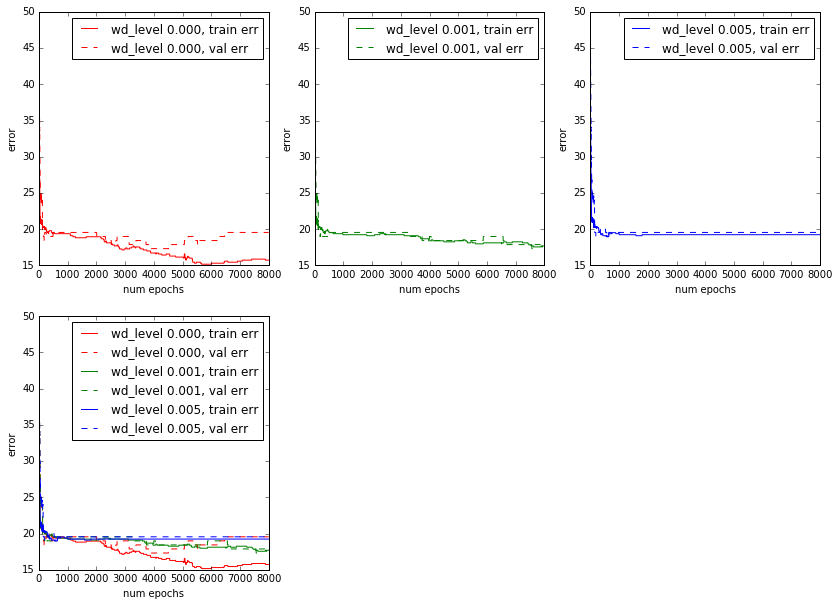

In [29]:
# Visualize results

plt.figure(figsize=(14,10))
num_epochs = len(train_errs_0)

plt.subplot(2, 3, 1)
plt.plot(range(num_epochs), train_errs_0, 'r', label='wd_level 0.000, train err')
plt.plot(range(num_epochs), val_errs_0, 'r--', label='wd_level 0.000, val err')
plt.xlabel('num epochs')
plt.ylabel('error')
plt.legend(loc='best')

plt.subplot(2, 3, 2)
plt.plot(range(num_epochs), train_errs_1, 'g', label='wd_level 0.001, train err')
plt.plot(range(num_epochs), val_errs_1, 'g--', label='wd_level 0.001, val err')
plt.xlabel('num epochs')
plt.ylabel('error')
plt.legend(loc='best')

plt.subplot(2, 3, 3)
plt.plot(range(num_epochs), train_errs_2, 'b', label='wd_level 0.005, train err')
plt.plot(range(num_epochs), val_errs_2, 'b--', label='wd_level 0.005, val err')
plt.xlabel('num epochs')
plt.ylabel('error')
plt.legend(loc='best')

plt.subplot(2, 3, 4)
plt.plot(range(num_epochs), train_errs_0, 'r', label='wd_level 0.000, train err')
plt.plot(range(num_epochs), val_errs_0, 'r--', label='wd_level 0.000, val err')
plt.plot(range(num_epochs), train_errs_1, 'g', label='wd_level 0.001, train err')
plt.plot(range(num_epochs), val_errs_1, 'g--', label='wd_level 0.001, val err')
plt.plot(range(num_epochs), train_errs_2, 'b', label='wd_level 0.005, train err')
plt.plot(range(num_epochs), val_errs_2, 'b--', label='wd_level 0.005, val err')
plt.xlabel('num epochs')
plt.ylabel('error')
plt.legend(loc='best')

Mình có đính kèm kết quả chạy của mình trong file `weight_decay.png`.

*TODO: Bình luận về đồ thị kết quả*

- Hình 1, với wd_level = 0.000, hai đường train err và val err tương đương nhau ở 4000 epoch đầu và ngày càng xa nhau (đường train err có xu hướng đi xuống, đường val err có xu hướng đi lên và chững lại) từ epoch 4000 trở đi.

- Hình 2, với wd_level = 0.001, hai đường train err và val err hầu như tương đương nhau trong suốt quá trình huấn luyện và độ lỗi có xu hướng xuống giảm dần chậm.

- Hình 3, với wd_level = 0.005, hai đường train err và val err hầu như tương đương nhau trong suốt quá trình huấn luyện, tuy nhiên độ lỗi hầu như chững lại (giữ nguyên) trong suốt quá trình huấn luyện.

- So sánh 3 hình, với wd_level = 0.001, hai đường train err và val err mặc dù có xu hướng ngày càng tách xa nhau nhưng nhìn chung độ lỗi của cả 2 đường rõ ràng thấp hơn độ lỗi của các đường train err và val err khác.

- Như vậy, thay vì huấn luyện với số lượng epoch lớn và lựa chọn kết quả từ epoch cuối, điều ta cần là tìm một bộ trọng số cho kết quả khả quan trên cả hai đường train err và val err tại một thời điểm huấn luyện nhất định.

**Thí nghiệm 2: ảnh hưởng của early stopping**

Để thấy được ảnh hưởng của early stopping tới quá trình học, ta sẽ huấn luyện Neural Net với `max_patience=5000`; ở đây, ta cố định `hid_layer_sizes=[50], wd_level=0.0, mb_size=len(train_X), learning_rate=0.1, max_epoch=1000000(default)`.

In [30]:
Ws_3, train_errs_3, val_errs_3 = train_nnet(train_X, train_Y, val_X, val_Y, hid_layer_sizes=[50], 
                                            wd_level=0.0, mb_size=len(train_X), learning_rate=0.1, 
                                            max_patience=5000)

Epoch   99, train err 21.348, val err 24.022 , patience 4972
Epoch  199, train err 20.084, val err 18.994 , patience 4981
Epoch  299, train err 19.522, val err 18.994 , patience 4881
Epoch  399, train err 19.803, val err 18.994 , patience 4781
Epoch  499, train err 19.522, val err 19.553 , patience 4681
Epoch  599, train err 19.382, val err 19.553 , patience 4581
Epoch  699, train err 19.382, val err 19.553 , patience 4481
Epoch  799, train err 19.382, val err 19.553 , patience 4381
Epoch  899, train err 19.382, val err 19.553 , patience 4281
Epoch  999, train err 19.382, val err 19.553 , patience 4181
Epoch 1099, train err 19.242, val err 19.553 , patience 4081
Epoch 1199, train err 18.961, val err 19.553 , patience 3981
Epoch 1299, train err 18.820, val err 19.553 , patience 3881
Epoch 1399, train err 18.820, val err 19.553 , patience 3781
Epoch 1499, train err 18.820, val err 19.553 , patience 3681
Epoch 1599, train err 18.820, val err 19.553 , patience 3581
Epoch 1699, train err 18

Kết quả của mình: 

`Info of returned Ws: epoch 3900, train err 16.713, val err 17.318`

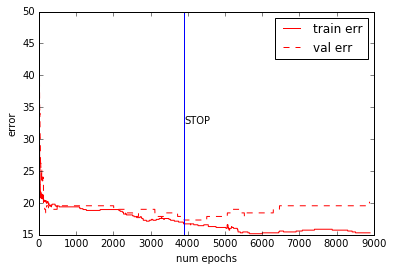

In [31]:
# Visualize results
num_epochs = len(train_errs_3)
stop_epoch = np.argmin(val_errs_3)
plt.plot(range(num_epochs), train_errs_3, 'r', label='train err')
plt.plot(range(num_epochs), val_errs_3, 'r--', label='val err')
min_y, max_y = plt.ylim()
plt.plot([stop_epoch, stop_epoch], [min_y, max_y])
plt.xlabel('num epochs')
plt.ylabel('error')
plt.legend(loc='best')
plt.text(stop_epoch, (min_y + max_y) / 2, 'STOP')

Mình có đính kèm kết quả chạy của mình trong file `early_stopping.png`.

*TODO: Bình luận về đồ thị kết quả*

- Một cách tổng quan, hai đường train err và val err gần như tương đương nhau sau 4000 epoch đầu tiên. Tuy nhiên, từ epoch 4000 trở đi, độ lỗi trên tập huấn luyện giảm dần tới gần 15%, còn độ lỗi trên tập validation thì tăng dần đến một thời điểm nhất định thì giữ nguyên ở mức khoảng 20%. 

- Việc huấn luyện với số lượng epoch càng lớn không đồng nghĩa kết quả đạt được luôn khả quan. Kiểm tra tập validation trong quá trình huấn luyện giúp chúng ta tìm được bộ trọng số phù hợp với cả tập huấn luyện và tập validation.

- Từ đồ thị trên, kết quả khả quan nhất là thời điểm epoch gần đạt 4000, với bộ trọng số cho độ lỗi thấp trên cả hai đường train err và val err (độ lỗi vào khoảng 17-18%), đồng thời độ chênh lệch độ lỗi giữa hai đường vào thời điểm này nhìn chung thấp (ở mức chấp nhận được).

## Kiểm tra (test)

Ta sẽ chọn `Ws` có độ lỗi nhỏ nhất trên tập validation làm bộ tham số của hàm dự đoán sau cùng; đó chính là `Ws_3` (dùng early stopping). Tất nhiên, ta có thể thí nghiệm thêm bằng cách kết hợp cả weight decay và early stopping (trong thực tế, người ta vẫn thường làm vậy, và có thể sẽ cho kết quả tốt hơn so với chỉ sử dụng weight decay hoặc early stopping). Mình đã có thí nghiệm nhưng độ lỗi trên tập validation không thấp hơn `Ws_3`; do đó, ta vẫn sẽ dùng `Ws_3` làm bộ tham số cuối cùng.

Để đánh giá chất lượng của `Ws_3`, ta sẽ tiến hành dự đoán với các véc-tơ đầu vào của tập kiểm tra, rồi submit kết quả dự đoán lên Kaggle để biết được độ chính xác.

**1. Đọc dữ liệu tập kiểm tra vào data frame `test_input_df`**

In [32]:
test_input_df = pd.read_csv('test.csv', index_col=0)
test_input_df.info()
test_input_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**2. Xây dựng `test_X` từ `test_input_df`**

In [33]:
test_X = process_new_input_df(test_input_df, dropped_cols, mean_mode_dict, X_mean, X_std)

**3. Dự đoán nhãn lớp của test_X**

In [34]:
# Predict
preds = np.argmax(compute_nnet_outputs(Ws_3, test_X, False), axis=1)

# Create a data frame with `PassengerId` column (ids of passengers in test set) 
# and `Survived` column (predictions); then write it to a csv file
preds_df = pd.DataFrame(preds, index=test_input_df.index, columns=['Survived'])
preds_df.head()
preds_df.to_csv('preds.csv')

*TODO: submit file `preds.csv` lên [Kaggle](https://www.kaggle.com/c/titanic/submissions/attach), và ghi nhận lại độ chính xác.*

Độ chính xác: 0.78469 (78.469%)